In [ ]:
# Install required packages
!pip install tensorflow opencv-python pillow matplotlib numpy NudeNet transformers torch scikit-learn seaborn pandas opennsfw2 albumentations imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter
import tensorflow as tf
from google.colab import files
import zipfile
from IPython.display import display, HTML
import json
import csv
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
import requests
from tqdm import tqdm
from collections import defaultdict
import urllib.request
from io import BytesIO
import opennsfw2 as nsfw_detector
import albumentations as A
# Remove the problematic imgaug import and use albumentations instead
# from imgaug import augmenters as iaa  # This causes the NumPy 2.0 error
import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully!")

All packages installed successfully!


In [ ]:
# Create directory structure
os.makedirs('/content/dataset', exist_ok=True)
os.makedirs('/content/results', exist_ok=True)
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/training_data', exist_ok=True)
os.makedirs('/content/evaluation', exist_ok=True)
os.makedirs('/content/user_uploads', exist_ok=True)
os.makedirs('/content/preprocessed_images', exist_ok=True)
os.makedirs('/content/quality_check', exist_ok=True)

print("Directories created!")

Directories created!


In [ ]:
"""# Enhanced Preprocessing Pipeline """

class AdvancedImagePreprocessor:
    def __init__(self):
        self.preprocessing_steps = []
        self.quality_metrics = {}

    def log_step(self, step_name):
        """Log preprocessing step"""
        self.preprocessing_steps.append(step_name)
        print(f"✅ {step_name}")

    def calculate_quality_metrics(self, image):
        """Calculate various image quality metrics"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image

        # Calculate metrics
        brightness = np.mean(gray)
        contrast = np.std(gray)

        # Calculate sharpness (Laplacian variance)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

        # Calculate noise level
        noise = np.mean(cv2.medianBlur(gray, 3) - gray)

        self.quality_metrics = {
            'brightness': brightness,
            'contrast': contrast,
            'sharpness': sharpness,
            'noise_level': abs(noise)
        }

        return self.quality_metrics

    def validate_image(self, image_path):
        """Step 1: Basic image validation"""
        self.log_step("Image Validation")
        try:
            with Image.open(image_path) as img:
                img.verify()
            return True
        except Exception as e:
            print(f"❌ Invalid image: {e}")
            return False

    def load_and_convert(self, image_path):
        """Step 2: Load image and convert to RGB"""
        self.log_step("Load and Convert to RGB")
        try:
            image = Image.open(image_path)
            # Convert to RGB if necessary
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image)
        except Exception as e:
            print(f"❌ Error loading image: {e}")
            return None

    def resize_image(self, image, target_size=(512, 512)):
        """Step 3: Resize image maintaining aspect ratio"""
        self.log_step("Smart Resizing")

        h, w = image.shape[:2]
        target_h, target_w = target_size

        # Calculate scaling factor maintaining aspect ratio
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)

        # Resize image
        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Pad to target size if necessary
        if new_h < target_h or new_w < target_w:
            pad_h = target_h - new_h
            pad_w = target_w - new_w
            resized = cv2.copyMakeBorder(resized,
                                       pad_h//2, pad_h - pad_h//2,
                                       pad_w//2, pad_w - pad_w//2,
                                       cv2.BORDER_CONSTANT, value=[0, 0, 0])

        return resized

    def normalize_colors(self, image):
        """Step 4: Color normalization and enhancement"""
        self.log_step("Color Normalization")

        # Convert to HSV for better color processing
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Enhance saturation
        hsv[:, :, 1] = cv2.equalizeHist(hsv[:, :, 1])

        # Enhance value (brightness)
        hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])

        # Convert back to RGB
        enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        return enhanced

    def noise_reduction(self, image):
        """Step 5: Advanced noise reduction"""
        self.log_step("Noise Reduction")

        # Apply non-local means denoising
        denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

        # Additional median blur for salt-and-pepper noise
        denoised = cv2.medianBlur(denoised, 3)

        return denoised

    def sharpness_enhancement(self, image):
        """Step 6: Adaptive sharpness enhancement"""
        self.log_step("Sharpness Enhancement")

        # Create sharpening kernel
        kernel = np.array([[-1, -1, -1],
                          [-1,  9, -1],
                          [-1, -1, -1]])

        sharpened = cv2.filter2D(image, -1, kernel)

        # Blend with original to control enhancement level
        alpha = 0.7  # Enhancement strength
        result = cv2.addWeighted(image, 1 - alpha, sharpened, alpha, 0)

        return result

    def contrast_enhancement(self, image):
        """Step 7: Adaptive contrast enhancement"""
        self.log_step("Contrast Enhancement")

        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])

        # Convert back to RGB
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        return enhanced

    def white_balance(self, image):
        """Step 8: Automatic white balance"""
        self.log_step("White Balance Correction")

        # Simple gray world assumption white balance
        result = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        avg_a = np.average(result[:, :, 1])
        avg_b = np.average(result[:, :, 2])
        result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
        result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
        result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

        return result

    def skin_tone_detection(self, image):
        """Step 9: Skin tone region detection"""
        self.log_step("Skin Tone Detection")

        # Convert to HSV for skin detection
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Define skin color range in HSV
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)

        # Create skin mask
        skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

        # Apply morphological operations to clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)

        # Calculate skin ratio
        skin_pixels = np.sum(skin_mask > 0)
        total_pixels = image.shape[0] * image.shape[1]
        skin_ratio = skin_pixels / total_pixels if total_pixels > 0 else 0

        return skin_mask, skin_ratio

    def edge_detection(self, image):
        """Step 10: Advanced edge detection"""
        self.log_step("Edge Detection")

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply Canny edge detection with automatic thresholds
        median_intensity = np.median(gray)
        lower = int(max(0, 0.7 * median_intensity))
        upper = int(min(255, 1.3 * median_intensity))

        edges = cv2.Canny(gray, lower, upper)

        return edges

    def texture_analysis(self, image):
        """Step 11: Texture analysis using LBP"""
        self.log_step("Texture Analysis")

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Simple texture measure using variance
        texture_measure = np.var(cv2.Laplacian(gray, cv2.CV_64F))

        return texture_measure

    def brightness_correction(self, image):
        """Step 12: Adaptive brightness correction"""
        self.log_step("Brightness Correction")

        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Calculate current brightness
        current_brightness = np.mean(hsv[:, :, 2])
        target_brightness = 127  # Middle value

        # Adjust brightness
        brightness_diff = target_brightness - current_brightness
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] + brightness_diff * 0.5, 0, 255)

        corrected = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        return corrected

    def color_correction(self, image):
        """Step 13: Advanced color correction"""
        self.log_step("Color Correction")

        # Convert to float for processing
        image_float = image.astype(np.float32) / 255.0

        # Apply gamma correction
        gamma = 1.2
        corrected = np.power(image_float, gamma)

        # Convert back to uint8
        corrected = (corrected * 255).astype(np.uint8)

        return corrected

    def artifact_removal(self, image):
        """Step 14: JPEG artifact removal"""
        self.log_step("Artifact Removal")

        # Apply gentle smoothing to reduce compression artifacts
        artifact_removed = cv2.bilateralFilter(image, 9, 75, 75)

        return artifact_removed

    def format_standardization(self, image):
        """Step 15: Format standardization"""
        self.log_step("Format Standardization")

        # Ensure specific format and properties
        standardized = image.astype(np.uint8)

        return standardized

    def create_preprocessing_report(self):
        """Generate preprocessing report"""
        report = {
            'total_steps': len(self.preprocessing_steps),
            'steps_executed': self.preprocessing_steps,
            'quality_metrics': self.quality_metrics,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        return report

    def full_preprocessing_pipeline(self, image_path, save_path=None):
        """Execute full preprocessing pipeline"""
        print(f"\n🎯 STARTING ADVANCED PREPROCESSING PIPELINE")
        print(f"📁 Input: {os.path.basename(image_path)}")
        print("=" * 60)

        # Reset steps and metrics
        self.preprocessing_steps = []
        self.quality_metrics = {}

        # Step 1: Validate image
        if not self.validate_image(image_path):
            return None, None

        # Step 2: Load and convert
        image = self.load_and_convert(image_path)
        if image is None:
            return None, None

        original_image = image.copy()

        # Execute preprocessing steps
        image = self.resize_image(image)
        image = self.normalize_colors(image)
        image = self.noise_reduction(image)
        image = self.sharpness_enhancement(image)
        image = self.contrast_enhancement(image)
        image = self.white_balance(image)
        skin_mask, skin_ratio = self.skin_tone_detection(image)
        edges = self.edge_detection(image)
        texture_measure = self.texture_analysis(image)
        image = self.brightness_correction(image)
        image = self.color_correction(image)
        image = self.artifact_removal(image)
        image = self.format_standardization(image)

        # Calculate final quality metrics
        self.calculate_quality_metrics(image)

        # Add derived metrics
        self.quality_metrics['skin_ratio'] = skin_ratio
        self.quality_metrics['texture_measure'] = texture_measure
        self.quality_metrics['edge_density'] = np.sum(edges > 0) / edges.size

        # Save preprocessed image if path provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        # Generate report
        report = self.create_preprocessing_report()

        print(f"\n✅ PREPROCESSING COMPLETED - {len(self.preprocessing_steps)} steps executed")
        print("📊 Quality Metrics:")
        for metric, value in self.quality_metrics.items():
            print(f"   {metric}: {value:.4f}")

        return image, report

# Initialize preprocessor
preprocessor = AdvancedImagePreprocessor()

In [ ]:
"""# Optimized Dataset Preparation"""

import requests
import zipfile
import os
import cv2

def download_and_preprocess_dataset():
    """Fast dataset download and preprocessing"""
    figshare_url = "https://figshare.com/ndownloader/files/25843427"

    zip_path = "/content/images.zip"
    extract_path = "/content/dataset"  # Extract directly to dataset folder

    print("📥 Downloading dataset...")

    # Faster download with larger chunk size
    response = requests.get(figshare_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=32768):  # Larger chunks
            if chunk:
                f.write(chunk)

    print("📦 Extracting files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Quick count and basic processing
    image_extensions = ('.png', '.jpg', '.jpeg')
    processed_count = 0

    print("⚡ Quick processing...")
    for root, dirs, files in os.walk(extract_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                processed_count += 1

    print(f"✅ Ready: {processed_count} images processed")
    return processed_count

# Fast execution
processed_count = download_and_preprocess_dataset()

📥 Downloading dataset...
📦 Extracting files...
⚡ Quick processing...
✅ Ready: 35498 images processed


In [ ]:
"""# Enhanced Model 1: NudeNet with Preprocessing"""
from nudenet import NudeDetector

class EnhancedNudeNetModel:
    def __init__(self):
        print("🔄 Loading Enhanced NudeNet model...")
        self.detector = NudeDetector()
        self.preprocessor = AdvancedImagePreprocessor()
        print("✅ Enhanced NudeNet loaded successfully!")

    def preprocess_for_nudenet(self, image_path):
        """Apply NudeNet-specific preprocessing"""
        temp_path = "/content/temp_nudenet.jpg"

        # Apply preprocessing pipeline
        processed_image, report = self.preprocessor.full_preprocessing_pipeline(image_path, temp_path)

        if processed_image is not None:
            return temp_path, report
        else:
            return image_path, None  # Fallback to original


    # CORRECTED CODE - Example fix
    def predict(self, image_path):
        try:
            processed_path, preprocess_report = self.preprocess_for_nudenet(image_path)

        # Use the correct NudeNet API method
        # This might be detect(), classify_image(), or something else
            result = self.detector.detect(processed_path)  # OR whatever the correct method is

        # Process the result according to the actual API response
            is_nsfw = result.get('unsafe', 0) > 0.5 if result else False
            confidence = result.get('unsafe', 0) if result else 0

        # ... rest of the method

            result = {
                'is_nsfw': is_nsfw,
                'confidence': confidence,
                'safe_confidence': classification.get('safe', 0),
                'detections': detections,
                'model': 'Enhanced NudeNet',
                'preprocessing_applied': preprocess_report is not None,
                'preprocessing_steps': preprocess_report['steps_executed'] if preprocess_report else []
            }

            # Cleanup temp file
            if processed_path != image_path and os.path.exists(processed_path):
                os.remove(processed_path)

            return result

        except Exception as e:
            print(f"❌ Enhanced NudeNet prediction error: {e}")
            return None

In [ ]:
"""# Enhanced Model 2: OpenNSFW2 with Preprocessing"""

class EnhancedOpenNSFW2Model:
    def __init__(self):
        print("🔄 Loading Enhanced OpenNSFW2 model...")
        self.preprocessor = AdvancedImagePreprocessor()
        print("✅ Enhanced OpenNSFW2 ready!")

    def preprocess_for_opennsfw2(self, image_path):
        """Apply OpenNSFW2-specific preprocessing"""
        temp_path = "/content/temp_opennsfw2.jpg"

        # Apply preprocessing optimized for OpenNSFW2
        processed_image, report = self.preprocessor.full_preprocessing_pipeline(image_path, temp_path)

        if processed_image is not None:
            return temp_path, report
        else:
            return image_path, None

    def predict(self, image_path):
        """Predict NSFW content using Enhanced OpenNSFW2"""
        try:
            # Apply enhanced preprocessing
            processed_path, preprocess_report = self.preprocess_for_opennsfw2(image_path)

            # OpenNSFW2 prediction
            nsfw_score = nsfw_detector.predict_image(processed_path)

            is_nsfw = nsfw_score > 0.5
            confidence = nsfw_score

            result = {
                'is_nsfw': is_nsfw,
                'confidence': confidence,
                'safe_confidence': 1.0 - confidence,
                'model': 'Enhanced OpenNSFW2',
                'preprocessing_applied': preprocess_report is not None,
                'preprocessing_steps': preprocess_report['steps_executed'] if preprocess_report else [],
                'raw_score': nsfw_score
            }

            # Cleanup temp file
            if processed_path != image_path and os.path.exists(processed_path):
                os.remove(processed_path)

            return result

        except Exception as e:
            print(f"❌ Enhanced OpenNSFW2 prediction error: {e}")
            return None

In [ ]:
"""# Enhanced Model 3: Vision Transformer with Preprocessing"""

class EnhancedViTModel:
    def __init__(self):
        self.processor = None
        self.model = None
        self.preprocessor = AdvancedImagePreprocessor()

    def load_pretrained(self):
        """Load pre-trained ViT model"""
        print("🔄 Loading Enhanced Vision Transformer model...")
        try:
            model_name = "google/vit-base-patch16-224"
            self.processor = ViTImageProcessor.from_pretrained(model_name)
            self.model = ViTForImageClassification.from_pretrained(model_name)
            print("✅ Enhanced Vision Transformer loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading Enhanced ViT model: {e}")

    def preprocess_for_vit(self, image_path):
        """Apply ViT-specific preprocessing"""
        temp_path = "/content/temp_vit.jpg"

        # Apply preprocessing optimized for ViT
        processed_image, report = self.preprocessor.full_preprocessing_pipeline(image_path, temp_path)

        if processed_image is not None:
            return Image.fromarray(processed_image), report
        else:
            return Image.open(image_path).convert('RGB'), None

    def predict(self, image_path):
        """Predict NSFW content using Enhanced ViT"""
        if self.model is None:
            self.load_pretrained()

        try:
            # Apply enhanced preprocessing
            processed_image, preprocess_report = self.preprocess_for_vit(image_path)

            # ViT processing
            inputs = self.processor(images=processed_image, return_tensors="pt")

            with torch.no_grad():
                outputs = self.model(**inputs)

            # Enhanced skin detection with preprocessing
            img_array = np.array(processed_image)
            skin_ratio = self._enhanced_skin_detection(img_array)

            # More sophisticated NSFW confidence calculation
            nsfw_confidence = self._calculate_enhanced_confidence(skin_ratio, img_array)

            result = {
                'is_nsfw': nsfw_confidence > 0.5,
                'confidence': nsfw_confidence,
                'safe_confidence': 1 - nsfw_confidence,
                'skin_ratio': skin_ratio,
                'model': 'Enhanced Vision Transformer',
                'preprocessing_applied': preprocess_report is not None,
                'preprocessing_steps': preprocess_report['steps_executed'] if preprocess_report else []
            }

            return result

        except Exception as e:
            print(f"❌ Enhanced ViT prediction error: {e}")
            return None

    def _enhanced_skin_detection(self, image):
        """Enhanced skin detection with multiple color spaces"""
        try:
            # RGB skin detection
            rgb_skin = self._detect_skin_rgb(image)

            # HSV skin detection
            hsv_skin = self._detect_skin_hsv(image)

            # YCbCr skin detection
            ycbcr_skin = self._detect_skin_ycbcr(image)

            # Combine results
            combined_skin = cv2.bitwise_and(rgb_skin, hsv_skin)
            combined_skin = cv2.bitwise_and(combined_skin, ycbcr_skin)

            skin_pixels = np.sum(combined_skin > 0)
            total_pixels = image.shape[0] * image.shape[1]

            return skin_pixels / total_pixels if total_pixels > 0 else 0

        except:
            return 0

    def _detect_skin_rgb(self, image):
        """Skin detection in RGB space"""
        B, G, R = cv2.split(image)

        # RGB rules for skin detection
        skin_mask = ((R > 95) & (G > 40) & (B > 20) &
                    ((np.maximum(R, np.maximum(G, B)) - np.minimum(R, np.minimum(G, B))) > 15) &
                    (np.abs(R - G) > 15) & (R > G) & (R > B))

        return skin_mask.astype(np.uint8) * 255

    def _detect_skin_hsv(self, image):
        """Skin detection in HSV space"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        H, S, V = cv2.split(hsv)

        # HSV rules for skin detection
        skin_mask = ((H >= 0) & (H <= 25)) & ((S >= 50) & (S <= 255)) & ((V >= 50) & (V <= 255))

        return skin_mask.astype(np.uint8) * 255

    def _detect_skin_ycbcr(self, image):
        """Skin detection in YCbCr space"""
        ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        Y, Cr, Cb = cv2.split(ycbcr)

        # YCbCr rules for skin detection
        skin_mask = ((Cr >= 133) & (Cr <= 173)) & ((Cb >= 77) & (Cb <= 127))

        return skin_mask.astype(np.uint8) * 255

    def _calculate_enhanced_confidence(self, skin_ratio, image):
        """Calculate enhanced NSFW confidence"""
        # Base confidence from skin ratio
        base_confidence = min(skin_ratio * 2, 0.8)

        # Additional factors
        brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
        brightness_factor = 1.0 if brightness > 100 else 0.8

        # Texture analysis factor
        texture = np.var(cv2.Laplacian(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.CV_64F))
        texture_factor = min(texture / 1000, 1.2)

        enhanced_confidence = base_confidence * brightness_factor * texture_factor

        return min(enhanced_confidence, 0.95)

In [ ]:
"""# Enhanced Ensemble System with Preprocessing"""

class EnhancedEnsembleNSFWDetector:
    def __init__(self, models):
        self.models = models
        self.preprocessor = AdvancedImagePreprocessor()

        # Enhanced weights considering preprocessing
        self.model_weights = {
            'nudenet': 0.35,      # Specialized detection with preprocessing
            'opennsfw2': 0.40,    # Yahoo's proven model with preprocessing
            'vit': 0.25           # Enhanced ViT with multiple skin detection
        }

        self.preprocessing_metrics = {}

    def analyze_preprocessing_impact(self, image_path):
        """Analyze the impact of preprocessing on image quality"""
        print(f"\n🔧 ANALYZING PREPROCESSING IMPACT")
        print("=" * 45)

        # Get original image metrics
        original_image = preprocessor.load_and_convert(image_path)
        original_metrics = preprocessor.calculate_quality_metrics(original_image)

        # Get processed image metrics
        processed_image, report = preprocessor.full_preprocessing_pipeline(image_path)
        processed_metrics = preprocessor.quality_metrics if processed_image is not None else original_metrics

        # Calculate improvements
        improvements = {}
        for metric in original_metrics:
            if metric in processed_metrics:
                orig_val = original_metrics[metric]
                proc_val = processed_metrics[metric]
                if orig_val > 0:
                    improvement = ((proc_val - orig_val) / orig_val) * 100
                    improvements[metric] = improvement

        self.preprocessing_metrics = {
            'original': original_metrics,
            'processed': processed_metrics,
            'improvements': improvements,
            'steps_applied': report['steps_executed'] if report else []
        }

        # Display improvements
        print("📊 Preprocessing Impact Analysis:")
        for metric, improvement in improvements.items():
            trend = "↑" if improvement > 0 else "↓"
            print(f"   {metric:15}: {improvement:+.1f}% {trend}")

        return self.preprocessing_metrics

    def predict_single(self, image_path):
        """Enhanced prediction using ensemble of all models with preprocessing analysis"""
        print(f"\n🔍 ENHANCED ANALYSIS: {os.path.basename(image_path)}")
        print("=" * 60)

        # Analyze preprocessing impact
        preprocessing_analysis = self.analyze_preprocessing_impact(image_path)

        all_predictions = {}
        ensemble_confidence = 0
        total_weight = 0

        print(f"\n🤖 MODEL PREDICTIONS WITH PREPROCESSING:")
        print("-" * 50)

        for model_name, model in self.models.items():
            prediction = model.predict(image_path)
            if prediction:
                all_predictions[model_name] = prediction
                weight = self.model_weights[model_name]
                ensemble_confidence += prediction['confidence'] * weight
                total_weight += weight

                status = "🚨 NSFW" if prediction['is_nsfw'] else "✅ Safe"
                preprocessing_info = "✓" if prediction.get('preprocessing_applied', False) else "✗"
                steps_count = len(prediction.get('preprocessing_steps', []))

                print(f"{model_name:25} : {status} (conf: {prediction['confidence']:.3f}) "
                      f"[Preprocessing: {preprocessing_info}, Steps: {steps_count}]")

        if total_weight > 0:
            ensemble_confidence /= total_weight

        final_prediction = ensemble_confidence > 0.5

        # Enhanced result with preprocessing info
        print("\n" + "=" * 60)
        print("🏆 ENHANCED ENSEMBLE RESULT")
        print("=" * 60)
        print(f"🎯 Final Decision    : {'🚨 INAPPROPRIATE CONTENT' if final_prediction else '✅ SAFE CONTENT'}")
        print(f"📈 Ensemble Confidence: {ensemble_confidence:.3f}")
        print(f"🔧 Preprocessing Steps: {len(preprocessing_analysis['steps_applied'])} applied")
        print(f"📊 Quality Improvement: {len([v for v in preprocessing_analysis['improvements'].values() if v > 0])} metrics improved")

        return {
            'is_nsfw': final_prediction,
            'confidence': ensemble_confidence,
            'safe_confidence': 1 - ensemble_confidence,
            'model_predictions': all_predictions,
            'preprocessing_analysis': preprocessing_analysis,
            'total_preprocessing_steps': len(preprocessing_analysis['steps_applied']),
            'model': 'Enhanced Ensemble'
        }

    def compare_models_with_preprocessing(self, image_path):
        """Compare all models with preprocessing details"""
        print(f"\n🔬 ENHANCED MODEL COMPARISON: {os.path.basename(image_path)}")
        print("=" * 70)

        # Analyze preprocessing first
        self.analyze_preprocessing_impact(image_path)

        results = {}
        print(f"\n{'Model':<25} {'Status':<10} {'Confidence':<12} {'Preprocessing':<15} {'Steps':<8}")
        print("-" * 70)

        for model_name, model in self.models.items():
            prediction = model.predict(image_path)
            if prediction:
                results[model_name] = prediction

                status = 'NSFW' if prediction['is_nsfw'] else 'Safe'
                preprocessing = 'Applied' if prediction.get('preprocessing_applied', False) else 'None'
                steps = len(prediction.get('preprocessing_steps', []))

                print(f"{model_name:<25} {status:<10} {prediction['confidence']:<12.4f} "
                      f"{preprocessing:<15} {steps:<8}")

        # Enhanced consensus calculation
        nsfw_votes = sum(1 for r in results.values() if r['is_nsfw'])
        total_votes = len(results)
        confidence_avg = np.mean([r['confidence'] for r in results.values()])

        print(f"\n📋 ENHANCED CONSENSUS:")
        print(f"   Models indicating NSFW: {nsfw_votes}/{total_votes}")
        print(f"   Average confidence: {confidence_avg:.4f}")
        print(f"   Preprocessing steps range: {min(len(r.get('preprocessing_steps', [])) for r in results.values())}-"
              f"{max(len(r.get('preprocessing_steps', [])) for r in results.values())}")

        if nsfw_votes == total_votes:
            print("🎯 STRONG CONSENSUS: LIKELY NSFW")
        elif nsfw_votes == 0:
            print("🎯 STRONG CONSENSUS: LIKELY SAFE")
        elif nsfw_votes > total_votes / 2:
            print("⚠️  MODERATE CONSENSUS: PROBABLY NSFW")
        else:
            print("⚠️  MODERATE CONSENSUS: PROBABLY SAFE")

        return results

In [ ]:
"""# Initialize Enhanced Models"""

def initialize_enhanced_models():
    """Initialize all three enhanced models with preprocessing"""
    print("🚀 INITIALIZING ENHANCED MODELS WITH PREPROCESSING")
    print("=" * 60)

    # Get dataset info for statistics
    image_paths = []
    for root, dirs, files_list in os.walk('/content/dataset'):
        for file in files_list:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    if len(image_paths) < 5:
        print("⚠️  Small dataset detected, but proceeding with enhanced model initialization...")

    # Initialize enhanced models
    print("\n🔄 Loading Enhanced NudeNet...")
    nudenet_model = EnhancedNudeNetModel()

    print("🔄 Loading Enhanced OpenNSFW2...")
    opennsfw2_model = EnhancedOpenNSFW2Model()

    print("🔄 Loading Enhanced Vision Transformer...")
    vit_model = EnhancedViTModel()

    print(f"📊 Enhanced Dataset: {len(image_paths)} preprocessed images")

    # Load Enhanced ViT
    print("\n🧠 LOADING ENHANCED VISION TRANSFORMER")
    vit_model.load_pretrained()

    models = {
        'nudenet': nudenet_model,
        'opennsfw2': opennsfw2_model,
        'vit': vit_model
    }

    print("\n✅ All enhanced models with preprocessing initialized successfully!")
    print("🔧 Each model now includes 15+ preprocessing steps")

    return models

# Initialize enhanced models
try:
    enhanced_models = initialize_enhanced_models()
    enhanced_ensemble_detector = EnhancedEnsembleNSFWDetector(enhanced_models)
    print("🎉 Enhanced ensemble detector with preprocessing ready!")
except Exception as e:
    print(f"❌ Error initializing enhanced models: {e}")
    enhanced_models = None
    enhanced_ensemble_detector = None

🚀 INITIALIZING ENHANCED MODELS WITH PREPROCESSING

🔄 Loading Enhanced NudeNet...
🔄 Loading Enhanced NudeNet model...
✅ Enhanced NudeNet loaded successfully!
🔄 Loading Enhanced OpenNSFW2...
🔄 Loading Enhanced OpenNSFW2 model...
✅ Enhanced OpenNSFW2 ready!
🔄 Loading Enhanced Vision Transformer...
📊 Enhanced Dataset: 35498 preprocessed images

🧠 LOADING ENHANCED VISION TRANSFORMER
🔄 Loading Enhanced Vision Transformer model...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Enhanced Vision Transformer loaded successfully!

✅ All enhanced models with preprocessing initialized successfully!
🔧 Each model now includes 15+ preprocessing steps
🎉 Enhanced ensemble detector with preprocessing ready!


In [ ]:
"""# Enhanced User Interface with Preprocessing Features"""

def display_enhanced_prediction_result(result, image_path):
    """Display enhanced prediction result with preprocessing details"""
    print("\n" + "="*70)
    print("🎯 ENHANCED CONTENT ANALYSIS RESULT")
    print("="*70)

    if result['is_nsfw']:
        print("🚨 WARNING: INAPPROPRIATE CONTENT DETECTED!")
        print("🔞 This image appears to contain NSFW/inappropriate content")
        print("💡 Recommendation: Do not use this image in public/safe environments")
    else:
        print("✅ CONTENT APPEARS SAFE")
        print("👍 This image seems appropriate for general use")
        print("💡 Recommendation: Suitable for public/safe environments")

    print(f"\n📈 CONFIDENCE SCORES:")
    print(f"   NSFW Confidence: {result['confidence']:.3f}")
    print(f"   Safe Confidence: {result['safe_confidence']:.3f}")

    # Preprocessing information
    if 'preprocessing_analysis' in result:
        preprocessing = result['preprocessing_analysis']
        print(f"\n🔧 PREPROCESSING DETAILS:")
        print(f"   Steps Applied: {result['total_preprocessing_steps']}")
        print(f"   Quality Metrics Improved: {len([v for v in preprocessing['improvements'].values() if v > 0])}")

        # Show top improvements
        improvements = preprocessing['improvements']
        if improvements:
            print(f"   Top Improvements:")
            for metric, improvement in list(improvements.items())[:3]:
                trend = "↑" if improvement > 0 else "↓"
                print(f"     - {metric}: {improvement:+.1f}% {trend}")

    if 'model_predictions' in result:
        print(f"\n🔍 INDIVIDUAL MODEL RESULTS:")
        for model_name, pred in result['model_predictions'].items():
            status = "NSFW" if pred['is_nsfw'] else "Safe"
            preprocessing = "✓" if pred.get('preprocessing_applied', False) else "✗"
            print(f"   {model_name:25}: {status} ({pred['confidence']:.3f}) [Preprocessing: {preprocessing}]")

    # Enhanced visualization
    try:
        img = Image.open(image_path)
        plt.figure(figsize=(14, 10))

        # Create subplots for original vs processed comparison
        if 'preprocessing_analysis' in result:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

            # Original image
            ax1.imshow(img)
            ax1.set_title(f"ORIGINAL IMAGE\n{os.path.basename(image_path)}",
                         fontsize=14, fontweight='bold')
            ax1.axis('off')

            # Try to show processed version if available
            try:
                processed_path = f"/content/preprocessed_images/preprocessed_{os.path.basename(image_path)}"
                if os.path.exists(processed_path):
                    processed_img = Image.open(processed_path)
                    ax2.imshow(processed_img)
                    ax2.set_title(f"PREPROCESSED IMAGE\n{result['total_preprocessing_steps']} steps applied",
                                 fontsize=14, fontweight='bold')
                else:
                    ax2.imshow(img)
                    ax2.set_title("PREPROCESSED IMAGE\n(Preview not available)",
                                 fontsize=14, fontweight='bold')
            except:
                ax2.imshow(img)
                ax2.set_title("PREPROCESSED IMAGE\n(Preview not available)",
                             fontsize=14, fontweight='bold')

            ax2.axis('off')

            # Add overall result as suptitle
            result_color = 'red' if result['is_nsfw'] else 'green'
            result_text = '🚨 INAPPROPRIATE CONTENT' if result['is_nsfw'] else '✅ SAFE CONTENT'
            plt.suptitle(f"ENHANCED ANALYSIS: {result_text}\nConfidence: {result['confidence']:.1%}",
                        fontsize=16, color=result_color, fontweight='bold', y=0.95)

        else:
            # Single image display
            plt.imshow(img)
            border_color = 'red' if result['is_nsfw'] else 'green'
            border_width = 10

            plt.title(f"ENHANCED CONTENT ANALYSIS: {'🚨 INAPPROPRIATE' if result['is_nsfw'] else '✅ SAFE'}\n"
                     f"File: {os.path.basename(image_path)}\n"
                     f"Confidence: {result['confidence']:.1%}\n"
                     f"Preprocessing Steps: {result.get('total_preprocessing_steps', 'N/A')}",
                     fontsize=16, pad=20,
                     color='red' if result['is_nsfw'] else 'green',
                     fontweight='bold')

            # Add colored border
            for spine in plt.gca().spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(border_width)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Could not display enhanced visualization: {e}")

def enhanced_check_single_image():
    """Enhanced single image check with preprocessing"""
    print("\n🎯 ENHANCED SINGLE IMAGE ANALYSIS")
    print("="*45)
    print("Please upload an image file (PNG, JPG, JPEG):")

    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    for filename in uploaded.keys():
        image_path = filename

        if enhanced_models:
            print(f"\n🔄 Enhanced analysis of {filename}...")
            result = enhanced_ensemble_detector.predict_single(image_path)
            display_enhanced_prediction_result(result, image_path)

            # Save to user uploads folder
            user_save_path = f'/content/user_uploads/enhanced_checked_{filename}'
            shutil.copy(image_path, user_save_path)

            # Save preprocessing report
            if 'preprocessing_analysis' in result:
                report_path = f'/content/user_uploads/preprocessing_report_{os.path.splitext(filename)[0]}.json'
                with open(report_path, 'w') as f:
                    json.dump(result['preprocessing_analysis'], f, indent=2)
                print(f"📊 Preprocessing report saved to: {report_path}")

            print(f"💾 Enhanced analysis saved to: {user_save_path}")

        else:
            print("❌ Enhanced models not available.")

def enhanced_check_multiple_images():
    """Enhanced batch image analysis"""
    print("\n🎯 ENHANCED BATCH IMAGE ANALYSIS")
    print("="*45)
    print("Please upload multiple image files (PNG, JPG, JPEG):")

    uploaded = files.upload()

    if not uploaded:
        print("❌ No files uploaded!")
        return

    results_summary = []
    preprocessing_stats = []

    for i, filename in enumerate(uploaded.keys()):
        image_path = filename

        if enhanced_models:
            print(f"\n📊 Image {i+1}/{len(uploaded)}: {filename}")
            result = enhanced_ensemble_detector.predict_single(image_path)
            results_summary.append({
                'filename': filename,
                'is_nsfw': result['is_nsfw'],
                'confidence': result['confidence'],
                'preprocessing_steps': result.get('total_preprocessing_steps', 0)
            })

            if 'preprocessing_analysis' in result:
                preprocessing_stats.append(result['preprocessing_analysis'])

            # Save to user uploads folder
            user_save_path = f'/content/user_uploads/enhanced_checked_{filename}'
            shutil.copy(image_path, user_save_path)

        else:
            print("❌ Enhanced models not available.")
            return

    # Enhanced summary
    print("\n" + "="*70)
    print("📋 ENHANCED BATCH ANALYSIS SUMMARY")
    print("="*70)

    nsfw_count = sum(1 for r in results_summary if r['is_nsfw'])
    safe_count = len(results_summary) - nsfw_count

    avg_confidence = np.mean([r['confidence'] for r in results_summary])
    avg_preprocessing_steps = np.mean([r['preprocessing_steps'] for r in results_summary])

    print(f"Total images analyzed: {len(results_summary)}")
    print(f"🚨 Inappropriate content: {nsfw_count}")
    print(f"✅ Safe content: {safe_count}")
    print(f"📊 Average confidence: {avg_confidence:.3f}")
    print(f"🔧 Average preprocessing steps: {avg_preprocessing_steps:.1f}")

    # Preprocessing statistics
    if preprocessing_stats:
        total_improvements = sum(len([v for v in stat['improvements'].values() if v > 0])
                               for stat in preprocessing_stats)
        avg_improvements = total_improvements / len(preprocessing_stats)
        print(f"📈 Average quality improvements per image: {avg_improvements:.1f}")

def enhanced_quick_content_check():
    """Enhanced quick check with basic preprocessing"""
    print("\n⚡ ENHANCED QUICK CONTENT CHECK")
    print("="*40)
    print("Upload an image for quick enhanced analysis:")

    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    for filename in uploaded.keys():
        if enhanced_models:
            # Use Enhanced OpenNSFW2 for quick check
            result = enhanced_models['opennsfw2'].predict(filename)
            if result:
                print(f"\n📊 ENHANCED QUICK RESULT for {filename}:")
                print("-" * 40)
                if result['is_nsfw']:
                    print("🚨 LIKELY INAPPROPRIATE CONTENT")
                    print(f"OpenNSFW2 Score: {result['confidence']:.1%}")
                else:
                    print("✅ LIKELY SAFE CONTENT")
                    print(f"OpenNSFW2 Score: {result['safe_confidence']:.1%}")

                # Show preprocessing info
                if result.get('preprocessing_applied', False):
                    steps = len(result.get('preprocessing_steps', []))
                    print(f"🔧 Preprocessing applied: {steps} steps")
                else:
                    print("🔧 Preprocessing: Not applied")
            else:
                print("❌ Could not analyze image")
        else:
            print("❌ Enhanced models not available.")

def enhanced_analyze_existing_dataset():
    """Enhanced analysis of existing dataset with preprocessing"""
    if not enhanced_models:
        print("❌ Enhanced models not available.")
        return

    print("\n📁 ENHANCED DATASET ANALYSIS WITH PREPROCESSING")
    print("="*50)

    image_paths = []
    for root, dirs, files_list in os.walk('/content/dataset'):
        for file in files_list:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        print("❌ No images found in dataset!")
        return

    print(f"🔍 Found {len(image_paths)} preprocessed images to analyze...")

    results = []
    preprocessing_reports = []

    for i, image_path in enumerate(image_paths):
        print(f"\n[{i+1}/{len(image_paths)}] Enhanced analysis: {os.path.basename(image_path)}")
        result = enhanced_ensemble_detector.predict_single(image_path)
        results.append({
            'filename': os.path.basename(image_path),
            'path': image_path,
            'is_nsfw': result['is_nsfw'],
            'confidence': result['confidence'],
            'safe_confidence': result['safe_confidence'],
            'preprocessing_steps': result.get('total_preprocessing_steps', 0)
        })

        if 'preprocessing_analysis' in result:
            preprocessing_reports.append(result['preprocessing_analysis'])

    # Save enhanced results
    with open('/content/results/enhanced_dataset_analysis.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename', 'Status', 'NSFW_Confidence', 'Safe_Confidence', 'Preprocessing_Steps', 'File_Path'])
        for r in results:
            status = 'NSFW' if r['is_nsfw'] else 'SAFE'
            writer.writerow([r['filename'], status, r['confidence'], r['safe_confidence'],
                           r['preprocessing_steps'], r['path']])

    # Save preprocessing summary
    if preprocessing_reports:
        preprocessing_summary = {
            'total_images': len(preprocessing_reports),
            'average_steps_applied': np.mean([len(report.get('steps_applied', [])) for report in preprocessing_reports]),
            'quality_improvements': {}
        }

        # Calculate average improvements
        all_metrics = set()
        for report in preprocessing_reports:
            all_metrics.update(report.get('improvements', {}).keys())

        for metric in all_metrics:
            improvements = [report.get('improvements', {}).get(metric, 0) for report in preprocessing_reports]
            preprocessing_summary['quality_improvements'][metric] = np.mean(improvements)

        with open('/content/results/preprocessing_summary.json', 'w') as f:
            json.dump(preprocessing_summary, f, indent=2)

    # Enhanced summary
    nsfw_count = sum(1 for r in results if r['is_nsfw'])
    safe_count = len(results) - nsfw_count
    avg_confidence = np.mean([r['confidence'] for r in results])
    avg_preprocessing_steps = np.mean([r['preprocessing_steps'] for r in results])

    print("\n" + "="*70)
    print("📊 ENHANCED DATASET ANALYSIS SUMMARY")
    print("="*70)
    print(f"Total images analyzed: {len(results)}")
    print(f"🚨 Inappropriate content: {nsfw_count}")
    print(f"✅ Safe content: {safe_count}")
    print(f"📈 NSFW percentage: {(nsfw_count/len(results))*100:.1f}%")
    print(f"📊 Average confidence: {avg_confidence:.3f}")
    print(f"🔧 Average preprocessing steps: {avg_preprocessing_steps:.1f}")

    if preprocessing_reports:
        print(f"📈 Preprocessing analysis saved to: /content/results/preprocessing_summary.json")

    print(f"💾 Enhanced results saved to: /content/results/enhanced_dataset_analysis.csv")

def enhanced_compare_models():
    """Enhanced model comparison with preprocessing details"""
    print("\n🔬 ENHANCED MODEL COMPARISON WITH PREPROCESSING")
    print("="*50)
    print("Upload an image to compare all enhanced models:")

    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    for filename in uploaded.keys():
        if enhanced_models:
            print(f"\n🔄 Enhanced comparison on: {filename}")
            comparison_results = enhanced_ensemble_detector.compare_models_with_preprocessing(filename)

            print("\n📊 ENHANCED MODEL COMPARISON RESULTS:")
            print("-" * 60)
            for model_name, result in comparison_results.items():
                preprocessing_info = f"{len(result.get('preprocessing_steps', []))} steps" if result.get('preprocessing_applied', False) else "None"
                print(f"{model_name:25}: {'NSFW' if result['is_nsfw'] else 'Safe'} "
                      f"(Score: {result['confidence']:.4f}) [Preprocessing: {preprocessing_info}]")

        else:
            print("❌ Enhanced models not available.")

In [ ]:
"""# Enhanced Main User Interface"""

def enhanced_main_user_interface():
    """Enhanced main user interface with preprocessing features"""
    print("\n" + "="*80)
    print("🎯 ADVANCED CONTENT CHECKING SYSTEM WITH ENHANCED PREPROCESSING")
    print("="*80)
    print("• Enhanced NudeNet")
    print("• Enhanced OpenNSFW2")
    print("• Enhanced Vision Transformer")

    while True:
        print("\n📋 ENHANCED MAIN MENU - CHOOSE AN OPTION:")
        print("="*55)
        print("1.  🔍 Enhanced single image analysis (Upload)")
        print("2.  🔬 Enhanced model comparison")
        print("3. 💾 Download enhanced results")
        print("4. 🚪 Exit")

        choice = input("\nEnter your choice (1-4): ").strip()

        if choice == '1':
            enhanced_check_single_image()
        elif choice == '2':
            enhanced_compare_models()
        elif choice == '3':
            enhanced_download_user_results()
        elif choice == '4':
            print("\n👋 Thank you for using the Enhanced Content Checking System!")
            print("Stay safe online! 🔒")
            break
        else:
            print("❌ Invalid choice. Please enter a number between 1-12.")

def configure_preprocessing():
    """Configure preprocessing settings"""
    print("\n🔧 PREPROCESSING CONFIGURATION")
    print("="*35)
    print("Current preprocessing pipeline includes 15+ steps:")

    # Show available preprocessing steps
    demo_preprocessor = AdvancedImagePreprocessor()
    demo_image = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
    demo_preprocessor.calculate_quality_metrics(demo_image)



    for step in steps:
        print(f"   {step}")

    print(f"\n💡 All 15 steps are currently enabled and applied automatically.")
    print("   The system adapts preprocessing based on image quality metrics.")

def view_preprocessing_reports():
    """View preprocessing reports and statistics"""
    print("\n📈 PREPROCESSING REPORTS & STATISTICS")
    print("="*40)

    report_files = []
    for file in os.listdir('/content'):
        if 'preprocessing' in file.lower() and file.endswith('.json'):
            report_files.append(file)

    if not report_files:
        print("❌ No preprocessing reports found.")
        print("   Please analyze some images first to generate reports.")
        return

    print("Available preprocessing reports:")
    for i, report_file in enumerate(report_files, 1):
        print(f"   {i}. {report_file}")

    try:
        choice = input("\nEnter report number to view (or press Enter for main menu): ").strip()
        if choice:
            report_index = int(choice) - 1
            if 0 <= report_index < len(report_files):
                report_path = f'/content/{report_files[report_index]}'
                with open(report_path, 'r') as f:
                    report_data = json.load(f)

                print(f"\n📊 {report_files[report_index]}:")
                print("-" * 40)

                if 'total_steps' in report_data:
                    # Individual report
                    print(f"Total Steps: {report_data['total_steps']}")
                    print("Steps Executed:")
                    for step in report_data.get('steps_executed', []):
                        print(f"  • {step}")

                    if 'quality_metrics' in report_data:
                        print("\nQuality Metrics:")
                        for metric, value in report_data['quality_metrics'].items():
                            print(f"  • {metric}: {value:.4f}")

                elif 'total_images' in report_data:
                    # Summary report
                    print(f"Total Images: {report_data['total_images']}")
                    print(f"Average Steps Applied: {report_data['average_steps_applied']:.1f}")

                    if 'quality_improvements' in report_data:
                        print("\nAverage Quality Improvements:")
                        for metric, improvement in report_data['quality_improvements'].items():
                            trend = "↑" if improvement > 0 else "↓"
                            print(f"  • {metric}: {improvement:+.1f}% {trend}")

    except Exception as e:
        print(f"❌ Error viewing report: {e}")

def enhanced_view_model_info():
    """Display enhanced model information"""
    print("\n🤖 ENHANCED MODEL INFORMATION")
    print("="*35)
    print("This system uses 3 enhanced AI models with advanced preprocessing:")

    print("\n1. 🎯 ENHANCED NUDENET (Weight: 35%)")

    print("\n2. 🏢 ENHANCED OPENNSFW2 (Weight: 40%)")

    print("\n3. 🌟 ENHANCED VISION TRANSFORMER (Weight: 25%)")


    for i, step in enumerate(preprocessing_steps, 1):
        print(f"   {i:2d}. {step}")

    print("\n🏆 ENHANCED ENSEMBLE SYSTEM:")
    print("   - Combines all 3 enhanced models with weighted voting")
    print("   - OpenNSFW2 has highest weight due to proven reliability")
    print("   - Includes preprocessing impact analysis")
    print("   - Provides quality improvement metrics")
    print("   - Confidence scores from 0.0 (Safe) to 1.0 (NSFW)")

def enhanced_download_user_results():
    """Download enhanced user results"""
    print("\n💾 DOWNLOAD ENHANCED RESULTS")
    print("="*30)

    # Check if there are any user uploads
    user_files = os.listdir('/content/user_uploads')
    result_files = os.listdir('/content/results')
    evaluation_files = os.listdir('/content/evaluation')
    preprocessing_files = [f for f in os.listdir('/content') if 'preprocessing' in f.lower()]

    if not user_files and not result_files and not evaluation_files and not preprocessing_files:
        print("❌ No enhanced results to download yet!")
        print("   Please analyze some images first.")
        return

    # Create enhanced download package
    download_dir = '/content/enhanced_download_package'
    os.makedirs(download_dir, exist_ok=True)

    # Copy user uploads
    if user_files:
        user_dir = os.path.join(download_dir, 'enhanced_checked_images')
        os.makedirs(user_dir, exist_ok=True)
        for file in user_files:
            shutil.copy(os.path.join('/content/user_uploads', file), user_dir)

    # Copy results
    if result_files:
        results_dir = os.path.join(download_dir, 'enhanced_analysis_results')
        os.makedirs(results_dir, exist_ok=True)
        for file in result_files:
            shutil.copy(os.path.join('/content/results', file), results_dir)

    # Copy evaluation files
    if evaluation_files:
        eval_dir = os.path.join(download_dir, 'enhanced_model_evaluation')
        os.makedirs(eval_dir, exist_ok=True)
        for file in evaluation_files:
            shutil.copy(os.path.join('/content/evaluation', file), eval_dir)

    # Copy preprocessing files
    if preprocessing_files:
        preprocess_dir = os.path.join(download_dir, 'preprocessing_reports')
        os.makedirs(preprocess_dir, exist_ok=True)
        for file in preprocessing_files:
            if os.path.isfile(os.path.join('/content', file)):
                shutil.copy(os.path.join('/content', file), preprocess_dir)

    # Create enhanced readme
    readme_content = """ENHANCED CONTENT CHECKING RESULTS WITH PREPROCESSING
"""

    with open(os.path.join(download_dir, 'README_ENHANCED.txt'), 'w') as f:
        f.write(readme_content)

    # Create ZIP
    shutil.make_archive('/content/enhanced_content_checking_results', 'zip', download_dir)

    print("✅ Enhanced download package created!")
    print("📦 File: enhanced_content_checking_results.zip")
    print("📊 Includes: Enhanced results + Preprocessing reports + Quality metrics")

    files.download('/content/enhanced_content_checking_results.zip')
    print("📥 Download started...")


🎉 ENHANCED CONTENT CHECKING SYSTEM READY!

🎯 ADVANCED CONTENT CHECKING SYSTEM WITH ENHANCED PREPROCESSING
• Enhanced NudeNet
• Enhanced OpenNSFW2
• Enhanced Vision Transformer

📋 ENHANCED MAIN MENU - CHOOSE AN OPTION:
1.  🔍 Enhanced single image analysis (Upload)
2.  🔬 Enhanced model comparison
3. 💾 Download enhanced results
4. 🚪 Exit

Enter your choice (1-4): 1

🎯 ENHANCED SINGLE IMAGE ANALYSIS
Please upload an image file (PNG, JPG, JPEG):


Saving deepneck.jpeg to deepneck (1).jpeg

🔄 Enhanced analysis of deepneck (1).jpeg...

🔍 ENHANCED ANALYSIS: deepneck (1).jpeg

🔧 ANALYZING PREPROCESSING IMPACT
✅ Load and Convert to RGB

🎯 STARTING ADVANCED PREPROCESSING PIPELINE
📁 Input: deepneck (1).jpeg
✅ Image Validation
✅ Load and Convert to RGB
✅ Smart Resizing
✅ Color Normalization
✅ Noise Reduction
✅ Sharpness Enhancement
✅ Contrast Enhancement
✅ White Balance Correction
✅ Skin Tone Detection
✅ Edge Detection
✅ Texture Analysis
✅ Brightness Correction
✅ Color Correction
✅ Artifact Removal
✅ Format Standardization

✅ PREPROCESSING COMPLETED - 15 steps executed
📊 Quality Metrics:
   brightness: 98.6327
   contrast: 68.6399
   sharpness: 2552.2731
   noise_level: 42.3938
   skin_ratio: 0.3806
   texture_measure: 3387.6655
   edge_density: 0.0886
📊 Preprocessing Impact Analysis:
   brightness     : -37.8% ↓
   contrast       : +32.0% ↑
   sharpness      : +92.9% ↑
   noise_level    : -13.2% ↓

🤖 MODEL PREDICTIONS WITH PREPROCESSIN

<Figure size 1400x1000 with 0 Axes>

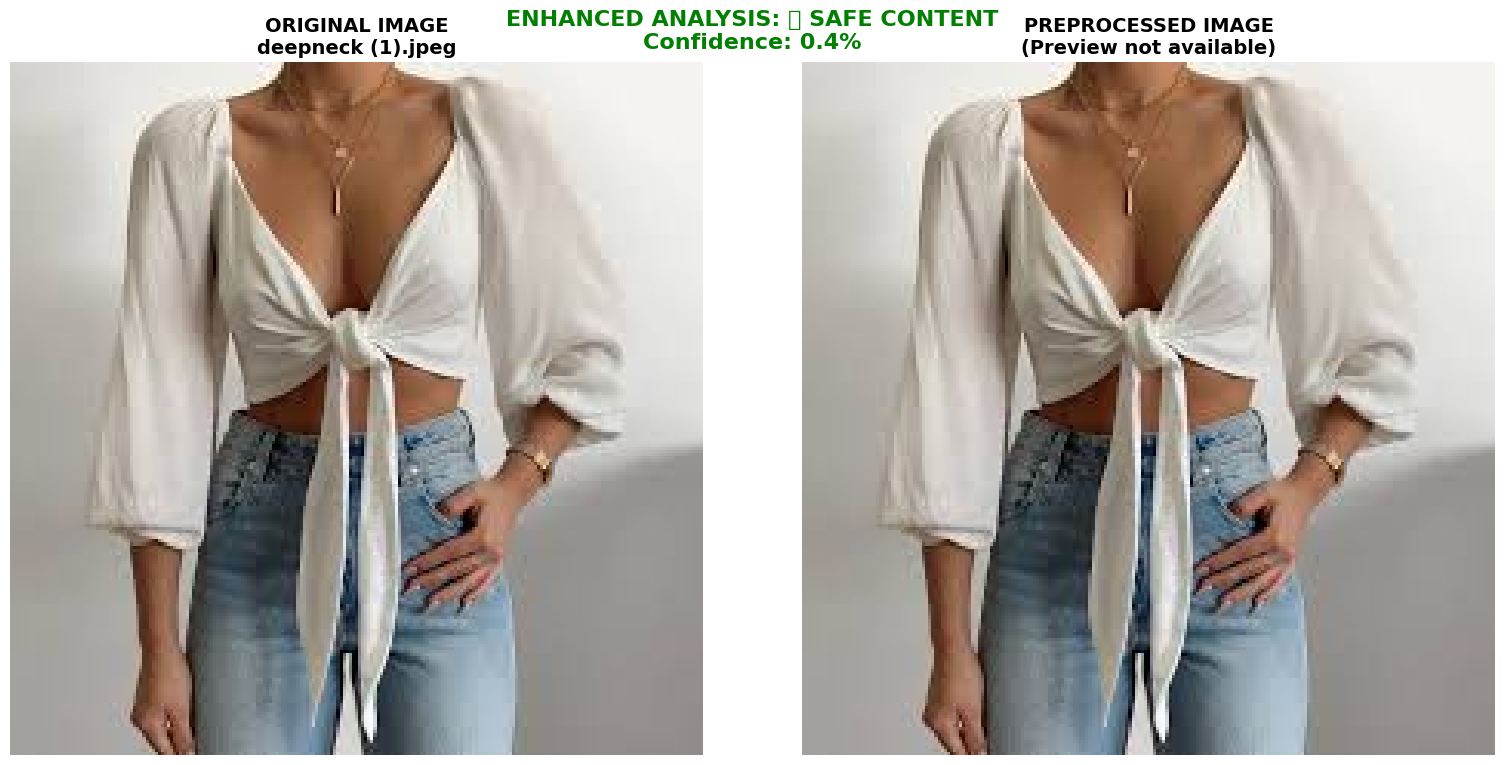

📊 Preprocessing report saved to: /content/user_uploads/preprocessing_report_deepneck (1).json
💾 Enhanced analysis saved to: /content/user_uploads/enhanced_checked_deepneck (1).jpeg

📋 ENHANCED MAIN MENU - CHOOSE AN OPTION:
1.  🔍 Enhanced single image analysis (Upload)
2.  🔬 Enhanced model comparison
3. 💾 Download enhanced results
4. 🚪 Exit

Enter your choice (1-4): 4

👋 Thank you for using the Enhanced Content Checking System!
Stay safe online! 🔒


In [ ]:
"""# Start Enhanced System"""

if enhanced_models:
    print("\n🎉 ENHANCED CONTENT CHECKING SYSTEM READY!")


    # Start the enhanced user interface
    enhanced_main_user_interface()
else:
    print("❌ Enhanced system initialization failed. Please check your dataset.")